# Execute the credit decision pipeline that is detecting age bias and removing using the reweighting algorithm
---

Machine learning has phenomenally improved the capability of data interpretation for making informed decisions in various fields and domains. Supervised machine learning has equipped systems to make predictions for new instances. The predicted values are driven by the model developed by trying to understand and devise a pattern in the training data in terms of the protected attributes.
	The systems fairness in making the prediction is thus dependent on the model and in turn the training data that has been provided to the generate the model. The issue in training data maybe insufficient data to make unbiased decision and or generating a prediction model which introduces bias in the system on specific attributes.

The credit decision pipeline is trained by the german credit data instances. The pipeline is inspected for bias on age as the protected attribute. An age of over ‘25’ is privileged with positive outcome while age less than ‘25’ is unprivileged. Following the machine learning pipeline, the instances are first divided into training and testing dataset. The model and prediction is then tested for bias in the credit decision by comparing the decision for privileged and unprivileged group. The process has dropped another protected attribute gender from the training dataset to reduce the influence of gender on the model and hence the prediction. 
	Binary Label dataset metric has been used to classify the training data as favorable and unfavorable for the protected attribute ‘age’. The mean difference in the outcomes of the two groups clearly indicates that a positive outcome of credit decision is 17% more likely for a privileged group with age >25. The bias is mitigated in the training dataset by reweighing or assigning more weight to the positive outcomes for privileged and unprivileged group for the attribute age. The effect is that the bias towards a negative outcome for the unprivileged group is mitigated by the increased weight of the positives. The re-trained system on the transformed dataset (by reweighing) results in a mean difference outcome of 0.0. Hence the reweighing has mitigated the bias in age attribute for the credit decision outcome prediction.


In [0]:
%pip install 'aif360 < 0.3.0'
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
sys.path.insert(1, "../")  
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt


     |████████████████████████████████| 56.4MB 70kB/s 


In [0]:
# Get the dataset and split into train and test

dataset_orig = GermanDataset(protected_attribute_names=['age'],          
              privileged_classes=[lambda x: x >= 25],    
   features_to_drop=['personal_status', 'sex'] )

dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]


    
all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
#np.random.seed(1)

In [0]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(700, 57)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['age']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192', 'foreign_wor

In [0]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.099901


In [0]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [0]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

In [0]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [0]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

In [0]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [0]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [0]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7770
Optimal classification threshold (no reweighing) = 0.7524


In [0]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [0]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    

#### Predictions from original testing data

100%|██████████| 100/100 [00:00<00:00, 773.10it/s]

Classification threshold used = 0.7524
Balanced accuracy = 0.7286
Statistical parity difference = -0.3308
Disparate impact = 0.4756
Average odds difference = -0.2653
Equal opportunity difference = -0.4556
Theil index = 0.2454


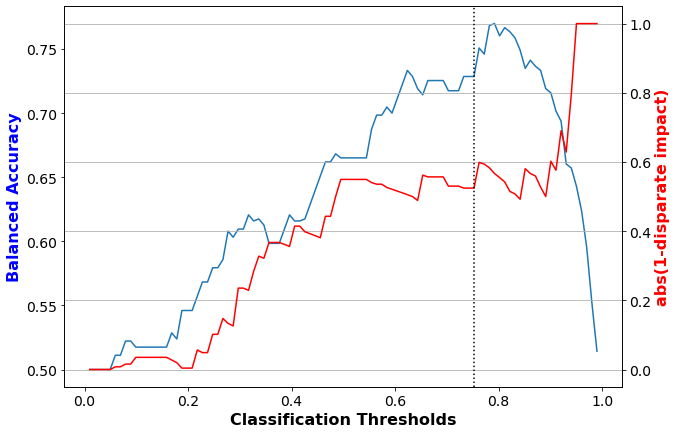

In [0]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

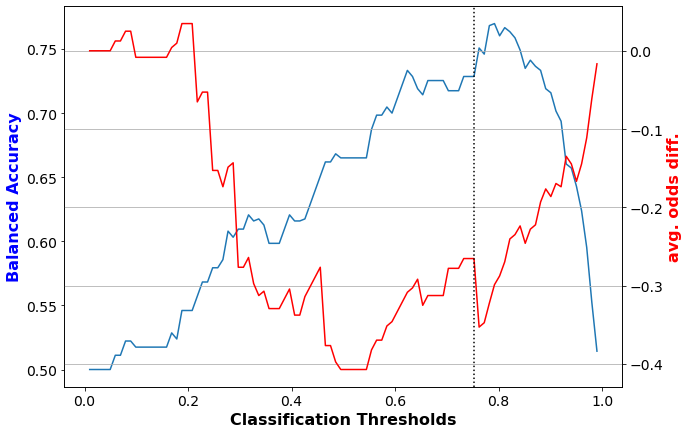

In [0]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [0]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [0]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [0]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

100%|██████████| 100/100 [00:00<00:00, 803.88it/s]

Classification threshold used = 0.7524
Balanced accuracy = 0.7429
Statistical parity difference = -0.2769
Disparate impact = 0.5200
Average odds difference = -0.2056
Equal opportunity difference = -0.4111
Theil index = 0.2734


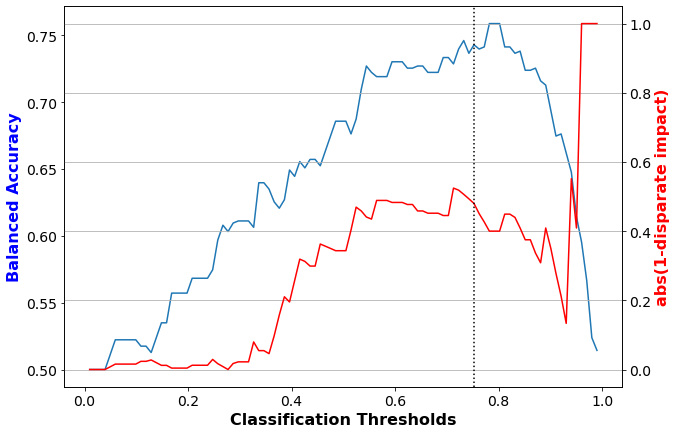

In [0]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

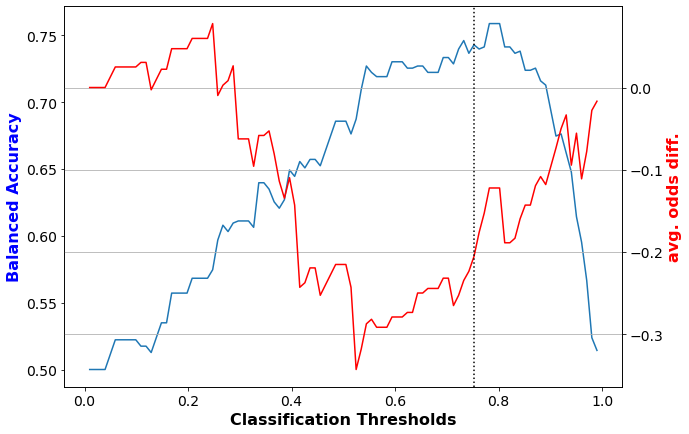

In [0]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)